## 主成分分析

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X    = iris.data
y    = iris.target

In [2]:
X.shape

(150, 4)

In [4]:
y.shape

(150,)

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [6]:
pca

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [9]:
X[0:3,:]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

In [10]:
X_reduced = pca.transform(X)

In [11]:
X_reduced[0:3,:]

array([[-2.68420713,  0.32660731],
       [-2.71539062, -0.16955685],
       [-2.88981954, -0.13734561]])

Populating the interactive namespace from numpy and matplotlib


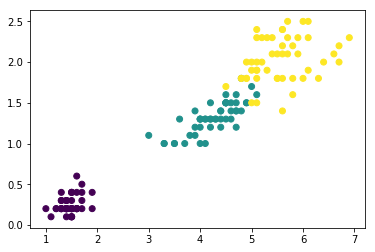

In [16]:
%pylab inline
from matplotlib import pyplot as plt
plt.scatter(X[:, 2], X[:, 3], c=y)
plt.show()

Populating the interactive namespace from numpy and matplotlib


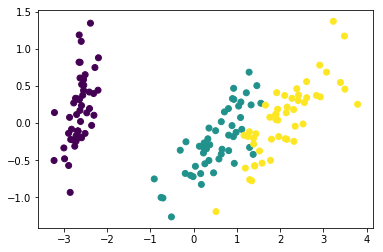

In [13]:
%pylab inline
from matplotlib import pyplot as plt
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y)
plt.show()

In [14]:
pca.components_

array([[ 0.36158968, -0.08226889,  0.85657211,  0.35884393],
       [ 0.65653988,  0.72971237, -0.1757674 , -0.07470647]])

In [15]:
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component, iris.feature_names)))

0.362 x sepal length (cm) + -0.082 x sepal width (cm) + 0.857 x petal length (cm) + 0.359 x petal width (cm)
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.176 x petal length (cm) + -0.075 x petal width (cm)


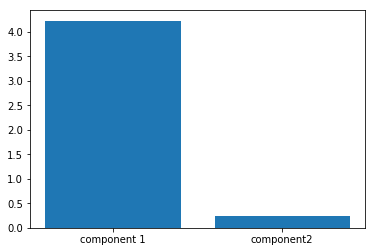

In [17]:
plt.bar(range(0,2), pca.explained_variance_)
plt.xticks(range(0,2), ['component 1', 'component2'])
plt.show()

In [18]:
from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(X_reduced, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

def plot_estimator(estimator, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.plot()
    plt.contourf(xx, yy, Z, alpha=0.4, cmap = plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y,  cmap = plt.cm.brg)
    plt.xlabel('Component1')
    plt.ylabel('Component2')
    plt.show()

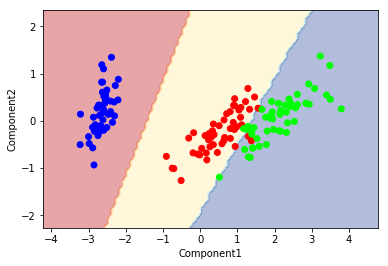

In [20]:

plot_estimator(clf, X_reduced, y)

In [23]:
predicted = clf.predict(X_reduced)

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y, predicted)

0.9666666666666667

In [26]:
confusion_matrix(y, predicted)

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  2, 48]], dtype=int64)

## 利用自編碼網路重建影像

In [35]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [36]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [37]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [38]:

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [39]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### 讀取MNIST數據

In [40]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [44]:
x_train= x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255.
x_train= x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### 訓練模型

In [47]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.1037 - val_loss: 0.1019
Epoch 2/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.1034 - val_loss: 0.1016
Epoch 3/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.1031 - val_loss: 0.1013
Epoch 4/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.1028 - val_loss: 0.1011
Epoch 5/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.1026 - val_loss: 0.1008
Epoch 6/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.1023 - val_loss: 0.1006
Epoch 7/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.1021 - val_loss: 0.1004
Epoch 8/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.1019 - val_loss: 0.1002
Epoch 9/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.1017 - val_loss: 0.1000
Epoch

### 檢視編碼與重建數據 

In [48]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
encoded_imgs.shape

(10000, 32)

In [49]:
1 / 24.5

0.04081632653061224

In [50]:
decoded_imgs = decoder.predict(encoded_imgs)

In [52]:
decoded_imgs.shape

(10000, 784)

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


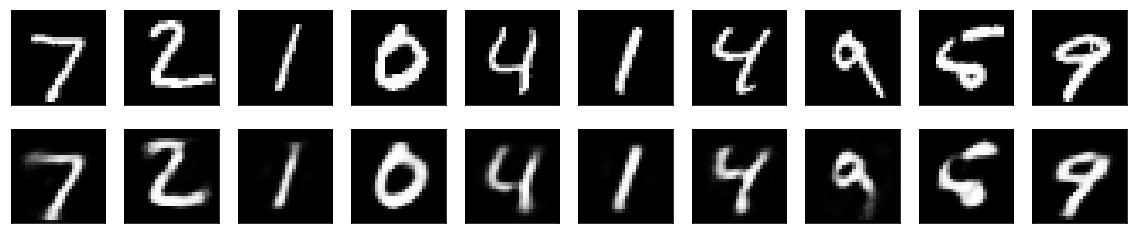

In [54]:
%pylab inline
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()